In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import splitfolders

In [2]:
# splits dataset it into three subfolders: train, val (validation), and test.

splitfolders.ratio(r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Driver Drowsiness detection using deep learning\Dataset", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 288 files [00:00, 409.76 files/s]


In [7]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [8]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [9]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
2 folder and 0 images in output\test
0 folder and 9 images in output\test\Active Driver
0 folder and 6 images in output\test\Drowsiness
2 folder and 0 images in output\train
0 folder and 126 images in output\train\Active Driver
0 folder and 90 images in output\train\Drowsiness
2 folder and 0 images in output\val
0 folder and 33 images in output\val\Active Driver
0 folder and 24 images in output\val\Drowsiness


In [10]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (100, 100)


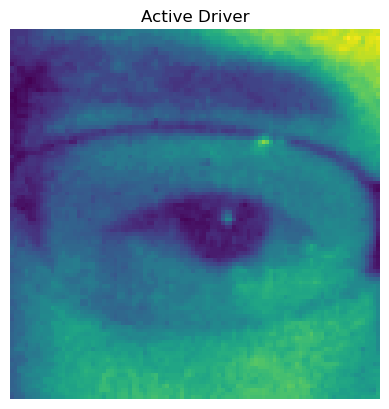

In [11]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Active Driver')

Image Shape : (80, 80)


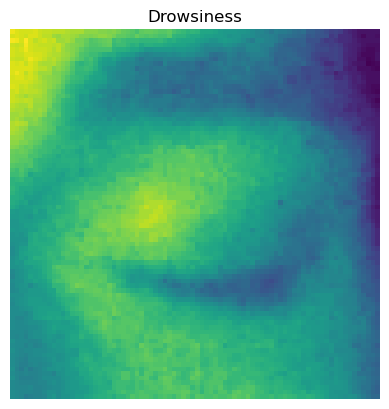

In [12]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Drowsiness')

In [13]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [14]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 216 images belonging to 2 classes.
Found 57 images belonging to 2 classes.
Found 15 images belonging to 2 classes.


In [15]:
train_data.class_indices

{'Active Driver': 0, 'Drowsiness': 1}

In [16]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [17]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (128,)
val_y.shape:  (33,)
test_y.shape:  (10,)


In [18]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

In [19]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(2)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         5,125 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,042,629 (26.87 MB)

 Trainable params: 5,125 (20.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [21]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# train model
history = model.fit(train_data, epochs=50, validation_data=valid_data)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 106s 26s/step - accuracy: 0.6823 - loss: 1.0143 - val_accuracy: 0.4848 - val_loss: 1.2755
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 11s/step - accuracy: 0.7083 - loss: 1.0228 - val_accuracy: 0.5455 - val_loss: 1.2479
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 9s/step - accuracy: 0.7135 - loss: 0.9587 - val_accuracy: 0.5758 - val_loss: 1.2287
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 9s/step - accuracy: 0.6667 - loss: 1.0570 - val_accuracy: 0.5152 - val_loss: 1.2200
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.6875 - loss: 0.9628 - val_accuracy: 0.4848 - val_loss: 1.2123
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.7083 - loss: 0.9283 - val_accuracy: 0.5152 - val_loss: 1.2075
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.7552 - loss: 0.8965 - val_accuracy: 0.5152 - val_loss: 1.1990
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.6823 - loss: 0.9423 - val_accuracy: 0.4848 - val_loss: 1.1923
Epoch

In [30]:
model.save('my_model.keras')